In [7]:
## Volcanp Plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

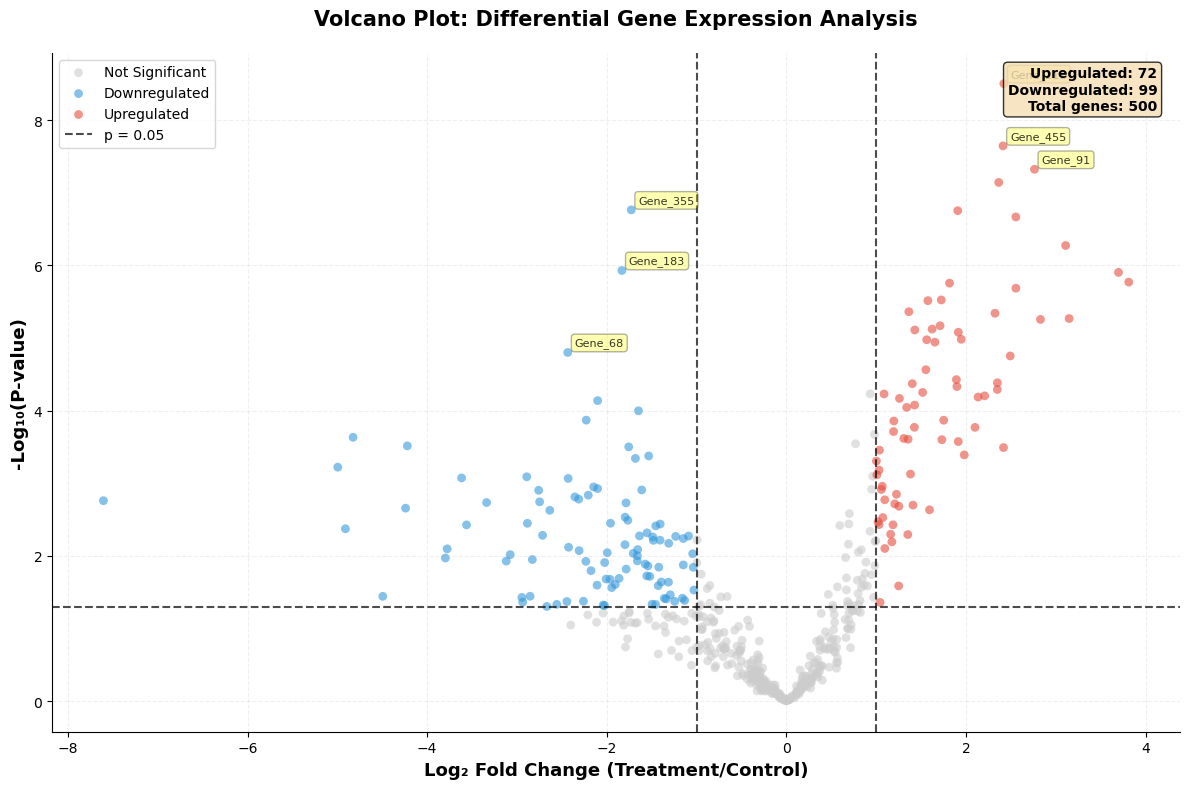


VOLCANO PLOT SUMMARY STATISTICS

Total genes analyzed: 500
Significantly upregulated genes: 72
Significantly downregulated genes: 99
Not significant: 329

Significance criteria:
  - |Log2 Fold Change| > 1.0 (≥2.0-fold change)
  - P-value < 0.05

------------------------------------------------------------
TOP 5 UPREGULATED GENES:
------------------------------------------------------------
Gene_357     | Log2FC:   3.81 | P-value: 1.70e-06
Gene_223     | Log2FC:   3.70 | P-value: 1.25e-06
Gene_104     | Log2FC:   3.15 | P-value: 5.38e-06
Gene_252     | Log2FC:   3.11 | P-value: 5.32e-07
Gene_60      | Log2FC:   2.83 | P-value: 5.54e-06

------------------------------------------------------------
TOP 5 DOWNREGULATED GENES:
------------------------------------------------------------
Gene_421     | Log2FC:  -7.61 | P-value: 1.73e-03
Gene_298     | Log2FC:  -5.00 | P-value: 5.99e-04
Gene_215     | Log2FC:  -4.91 | P-value: 4.22e-03
Gene_278     | Log2FC:  -4.83 | P-value: 2.32e-04
Gene_2

In [14]:
# ============================================================================
# VOLCANO PLOT GENERATOR WITH SAMPLE DATA
# ============================================================================
# This script generates a volcano plot for differential gene expression analysis
# A volcano plot displays:
# - X-axis: Log2 Fold Change (how much expression changed)
# - Y-axis: -Log10(P-value) (statistical significance)
# ============================================================================

import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from scipy import stats  # For statistical tests

# Set random seed for reproducibility (same results every time)
np.random.seed(42)

# ============================================================================
# STEP 1: GENERATE SAMPLE GENE EXPRESSION DATA
# ============================================================================
# Define the number of genes to simulate
n_genes = 500

# Create gene names (Gene_1, Gene_2, ..., Gene_500)
genes = [f'Gene_{i+1}' for i in range(n_genes)]

# ============================================================================
# Generate CONTROL samples (baseline/untreated condition)
# ============================================================================
# We simulate 6 biological replicates for the control group
# Using gamma distribution to mimic real gene expression data
# - shape=2, scale=300 creates realistic expression values (100-1000 range)
control_data = {}
for i in range(1, 7):
    # Each control replicate has expression values for all genes
    control_data[f'Control{i}'] = np.random.gamma(shape=2, scale=300, size=n_genes)

# ============================================================================
# Generate TREATMENT samples (experimental condition)
# ============================================================================
# We simulate 6 biological replicates for the treatment group
treatment_data = {}
# Start with baseline expression similar to controls
base_treatment = np.random.gamma(shape=2, scale=300, size=n_genes)

# Now we'll artificially create differentially expressed genes:
# - Some genes will be UPREGULATED (increased expression in treatment)
# - Some genes will be DOWNREGULATED (decreased expression in treatment)

# Select 50 random genes to be upregulated (2-4 fold increase)
upregulated_idx = np.random.choice(n_genes, 50, replace=False)

# Select 50 different random genes to be downregulated (2-4 fold decrease)
downregulated_idx = np.random.choice(
    list(set(range(n_genes)) - set(upregulated_idx)), 50, replace=False
)

# Create 6 treatment replicates with differential expression
for i in range(1, 7):
    treatment_vals = base_treatment.copy()
    
    # Increase expression for upregulated genes (2-4 fold)
    treatment_vals[upregulated_idx] *= np.random.uniform(2, 4, len(upregulated_idx))
    
    # Decrease expression for downregulated genes (0.25-0.5 fold = 2-4 fold decrease)
    treatment_vals[downregulated_idx] *= np.random.uniform(0.25, 0.5, len(downregulated_idx))
    
    # Add biological noise (10% variation) to make it realistic
    treatment_vals *= np.random.normal(1, 0.1, n_genes)
    
    # Ensure all values are positive
    treatment_data[f'Treatment{i}'] = np.abs(treatment_vals)

# ============================================================================
# STEP 2: CREATE A DATAFRAME WITH ALL DATA
# ============================================================================
# Combine gene names with control and treatment data
df = pd.DataFrame({'Gene': genes})

# Add control data columns
for key, val in control_data.items():
    df[key] = val

# Add treatment data columns
for key, val in treatment_data.items():
    df[key] = val

# IMPORTANT: Convert all numeric columns to float type to avoid data type issues
# This ensures scipy's statistical functions work properly
numeric_columns = [col for col in df.columns if col != 'Gene']
df[numeric_columns] = df[numeric_columns].astype(float)

# ============================================================================
# STEP 3: IDENTIFY CONTROL AND TREATMENT COLUMNS
# ============================================================================
# Automatically find column names containing 'Control' or 'Treatment'
control_cols = [col for col in df.columns if 'Control' in col]
treatment_cols = [col for col in df.columns if 'Treatment' in col]

# ============================================================================
# STEP 4: CALCULATE MEAN EXPRESSION FOR EACH GROUP
# ============================================================================
# Average expression across all control replicates
df['Control_Mean'] = df[control_cols].mean(axis=1)

# Average expression across all treatment replicates
df['Treatment_Mean'] = df[treatment_cols].mean(axis=1)

# ============================================================================
# STEP 5: CALCULATE LOG2 FOLD CHANGE
# ============================================================================
# Fold Change = Treatment / Control
# Log2 Fold Change tells us:
#   - Positive values: gene is UPREGULATED in treatment
#   - Negative values: gene is DOWNREGULATED in treatment
#   - Log2FC = 1 means 2-fold increase
#   - Log2FC = -1 means 2-fold decrease (0.5x)
#
# Add small epsilon to avoid division by zero
epsilon = 1e-10
df['Log2FC'] = np.log2((df['Treatment_Mean'] + epsilon) / (df['Control_Mean'] + epsilon))

# ============================================================================
# STEP 6: PERFORM STATISTICAL TESTING (T-TEST)
# ============================================================================
# For each gene, we perform an independent t-test to compare:
# - Control group values vs Treatment group values
# This gives us a p-value indicating if the difference is statistically significant
# Lower p-value = more confident the difference is real (not random)

p_values = []
for idx, row in df.iterrows():
    # Get all control values for this gene and convert to numpy array of floats
    control_vals = row[control_cols].values.astype(float)
    
    # Get all treatment values for this gene and convert to numpy array of floats
    treatment_vals = row[treatment_cols].values.astype(float)
    
    # Perform independent samples t-test
    # Returns: t-statistic (we don't use) and p-value (we keep)
    t_stat, p_val = stats.ttest_ind(treatment_vals, control_vals)
    p_values.append(p_val)

# Add p-values to dataframe
df['P_value'] = p_values

# ============================================================================
# STEP 7: CALCULATE -LOG10(P-VALUE) FOR Y-AXIS
# ============================================================================
# We use -log10 transformation because:
# - Smaller p-values (more significant) become LARGER values
# - p-value of 0.05 becomes 1.3
# - p-value of 0.001 becomes 3
# - p-value of 0.00001 becomes 5
# This makes significant genes appear higher on the plot
df['Neg_Log10_P'] = -np.log10(df['P_value'] + epsilon)

# ============================================================================
# STEP 8: DEFINE SIGNIFICANCE THRESHOLDS
# ============================================================================
# These cutoffs determine which genes are considered "significant"
fc_threshold = 1.0  # Log2 fold change > 1 means > 2-fold change
p_threshold = 0.05  # P-value < 0.05 is commonly used for significance

# ============================================================================
# STEP 9: CLASSIFY GENES BY SIGNIFICANCE
# ============================================================================
# Genes must meet BOTH criteria to be considered significant:
# 1. Large fold change (|Log2FC| > 1)
# 2. Low p-value (p < 0.05)

# Start with all genes as "Not Significant"
df['Significance'] = 'Not Significant'

# Mark upregulated genes (high expression + significant)
df.loc[(df['Log2FC'] > fc_threshold) & (df['P_value'] < p_threshold), 'Significance'] = 'Upregulated'

# Mark downregulated genes (low expression + significant)
df.loc[(df['Log2FC'] < -fc_threshold) & (df['P_value'] < p_threshold), 'Significance'] = 'Downregulated'

# ============================================================================
# STEP 10: CREATE THE VOLCANO PLOT
# ============================================================================
# Create a figure with specified size (12 inches wide, 8 inches tall)
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each category
colors = {
    'Not Significant': '#CCCCCC',  # Light gray for non-significant genes
    'Upregulated': '#E74C3C',      # Red for upregulated genes
    'Downregulated': '#3498DB'     # Blue for downregulated genes
}

# Plot each category of genes separately
for category in ['Not Significant', 'Downregulated', 'Upregulated']:
    # Filter data for this category
    data = df[df['Significance'] == category]
    
    # Create scatter plot
    # X-axis: Log2 Fold Change, Y-axis: -Log10(P-value)
    ax.scatter(data['Log2FC'], data['Neg_Log10_P'], 
               c=colors[category],  # Color
               alpha=0.6,           # Transparency (0=invisible, 1=solid)
               s=40,                # Size of points
               label=category,      # Label for legend
               edgecolors='none')   # No border around points

# ============================================================================
# STEP 11: ADD THRESHOLD LINES
# ============================================================================
# Add horizontal line for p-value threshold (significance cutoff)
ax.axhline(y=-np.log10(p_threshold),  # Y position
           color='black', 
           linestyle='--',             # Dashed line
           linewidth=1.5, 
           alpha=0.7,                  # Slightly transparent
           label=f'p = {p_threshold}')

# Add vertical lines for fold change thresholds
# Right line (upregulation threshold)
ax.axvline(x=fc_threshold, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Left line (downregulation threshold)
ax.axvline(x=-fc_threshold, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# ============================================================================
# STEP 12: LABEL TOP DIFFERENTIALLY EXPRESSED GENES
# ============================================================================
# Find the 3 most significant upregulated genes
top_up = df[df['Significance'] == 'Upregulated'].nlargest(3, 'Neg_Log10_P')

# Find the 3 most significant downregulated genes
top_down = df[df['Significance'] == 'Downregulated'].nlargest(3, 'Neg_Log10_P')

# Add text labels for these top genes
for idx, row in pd.concat([top_up, top_down]).iterrows():
    ax.annotate(row['Gene'],  # Text to display
                xy=(row['Log2FC'], row['Neg_Log10_P']),  # Position of point
                xytext=(5, 5),  # Offset of text (5 pixels right and up)
                textcoords='offset points',
                fontsize=8, 
                alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3',  # Rounded box around text
                         facecolor='yellow',          # Yellow background
                         alpha=0.3))                  # Semi-transparent

# ============================================================================
# STEP 13: ADD LABELS, TITLE, AND STYLING
# ============================================================================
# X-axis label
ax.set_xlabel('Log₂ Fold Change (Treatment/Control)', fontsize=13, fontweight='bold')

# Y-axis label
ax.set_ylabel('-Log₁₀(P-value)', fontsize=13, fontweight='bold')

# Title
ax.set_title('Volcano Plot: Differential Gene Expression Analysis', 
             fontsize=15, fontweight='bold', pad=20)  # pad adds space above plot

# Add legend (shows what colors mean)
ax.legend(loc='upper left', frameon=True, fontsize=10)

# Add grid for easier reading
ax.grid(True, alpha=0.2, linestyle='--')

# Remove top and right borders for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ============================================================================
# STEP 14: ADD STATISTICS TEXT BOX
# ============================================================================
# Count genes in each category
up_count = sum(df['Significance'] == 'Upregulated')
down_count = sum(df['Significance'] == 'Downregulated')

# Create text with statistics
stats_text = f'Upregulated: {up_count}\nDownregulated: {down_count}\nTotal genes: {len(df)}'

# Add text box in top-right corner
ax.text(0.98, 0.98,           # Position (98% right, 98% up)
        stats_text, 
        transform=ax.transAxes,  # Use axes coordinates (0-1 scale)
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontsize=10, 
        fontweight='bold')

# ============================================================================
# STEP 15: SAVE AND DISPLAY THE PLOT
# ============================================================================
plt.tight_layout()  # Adjust spacing to prevent label cutoff
plt.savefig('volcano_plot.png', dpi=300, bbox_inches='tight')  # Save high-res image
plt.show()  # Display the plot

# ============================================================================
# STEP 16: PRINT SUMMARY STATISTICS TO CONSOLE
# ============================================================================
print("\n" + "="*60)
print("VOLCANO PLOT SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal genes analyzed: {len(df)}")
print(f"Significantly upregulated genes: {up_count}")
print(f"Significantly downregulated genes: {down_count}")
print(f"Not significant: {sum(df['Significance'] == 'Not Significant')}")

print(f"\nSignificance criteria:")
print(f"  - |Log2 Fold Change| > {fc_threshold} (≥{2**fc_threshold:.1f}-fold change)")
print(f"  - P-value < {p_threshold}")

# Show top 5 upregulated genes
print("\n" + "-"*60)
print("TOP 5 UPREGULATED GENES:")
print("-"*60)
top5_up = df[df['Significance'] == 'Upregulated'].nlargest(5, 'Log2FC')
for idx, row in top5_up.iterrows():
    print(f"{row['Gene']:12s} | Log2FC: {row['Log2FC']:6.2f} | P-value: {row['P_value']:.2e}")

# Show top 5 downregulated genes
print("\n" + "-"*60)
print("TOP 5 DOWNREGULATED GENES:")
print("-"*60)
top5_down = df[df['Significance'] == 'Downregulated'].nsmallest(5, 'Log2FC')
for idx, row in top5_down.iterrows():
    print(f"{row['Gene']:12s} | Log2FC: {row['Log2FC']:6.2f} | P-value: {row['P_value']:.2e}")

# ============================================================================
# STEP 17: SAVE RESULTS TO CSV FILE
# ============================================================================
# Select relevant columns to save
results = df[['Gene', 'Control_Mean', 'Treatment_Mean', 'Log2FC', 'P_value', 'Significance']]

# Sort by p-value (most significant first)
results = results.sort_values('P_value')

# Save to CSV file
results.to_csv('volcano_plot_results.csv', index=False)

print("\n" + "="*60)
print("Results saved to 'volcano_plot_results.csv'")
print("Plot saved to 'volcano_plot.png'")
print("="*60)

# ============================================================================
# END OF SCRIPT
# ============================================================================
# The volcano plot helps identify genes with:
# 1. Large expression changes (far left or right on X-axis)
# 2. High statistical confidence (high on Y-axis)
# 
# The best candidate genes are in the top-left and top-right corners
# (large fold change AND low p-value)
# ============================================================================

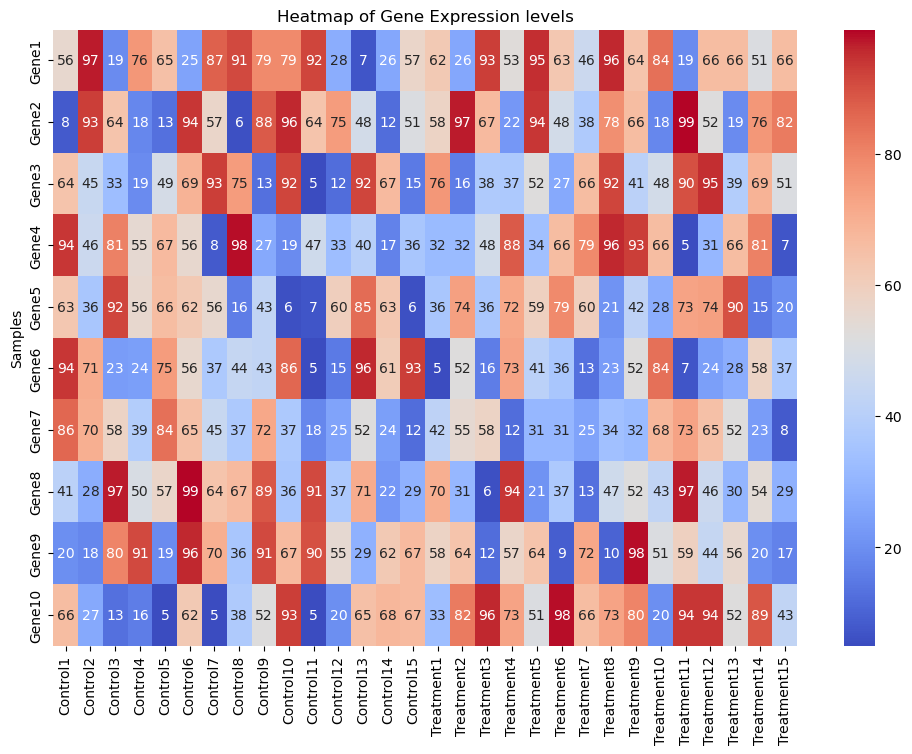

In [13]:
data=pd.read_csv("cancer_expression.csv")
data

## heatmap
heatmap_data=data.set_index('Gene')
heatmap= heatmap_data.head(10)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap,cmap="coolwarm",annot=True)
plt.title("Heatmap of Gene Expression levels")
plt.ylabel('Genes')
plt.ylabel('Samples')
plt.show()

Sample Data:
                Product A  Product B  Product C
Speed                  85         70         90
Reliability            90         85         70
User-Friendly          75         90         80
Cost-Effective         60         80         70
Features               80         65         90
Support                70         75         85



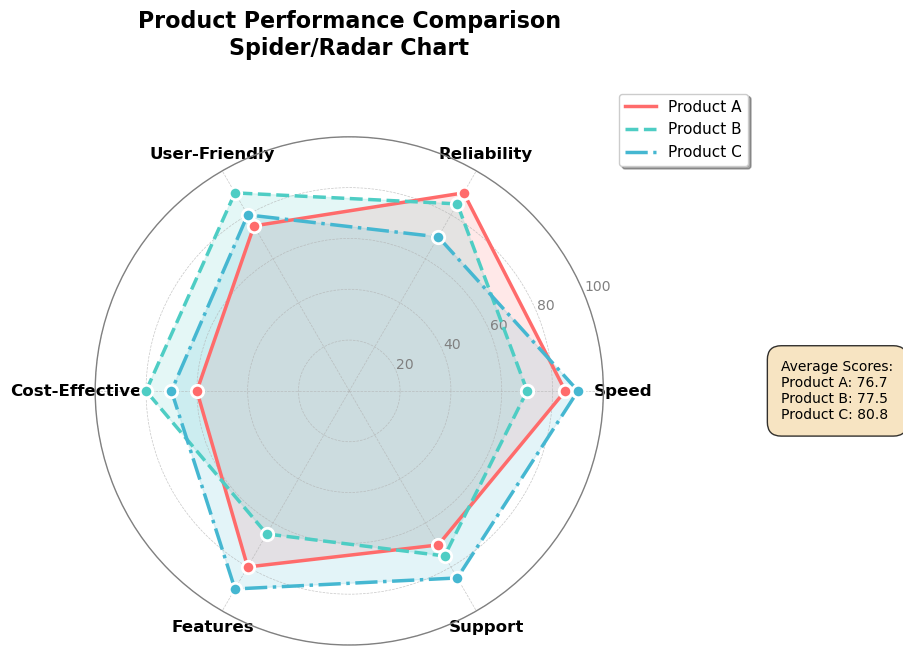


DETAILED ANALYSIS

Product A:
----------------------------------------
  Average Score: 76.7/100
  Strongest: Reliability (90/100)
  Weakest: Cost-Effective (60/100)

  Detailed Scores:
    Speed          : █████████████████░░░ 85/100
    Reliability    : ██████████████████░░ 90/100
    User-Friendly  : ███████████████░░░░░ 75/100
    Cost-Effective : ████████████░░░░░░░░ 60/100
    Features       : ████████████████░░░░ 80/100
    Support        : ██████████████░░░░░░ 70/100

Product B:
----------------------------------------
  Average Score: 77.5/100
  Strongest: User-Friendly (90/100)
  Weakest: Features (65/100)

  Detailed Scores:
    Speed          : ██████████████░░░░░░ 70/100
    Reliability    : █████████████████░░░ 85/100
    User-Friendly  : ██████████████████░░ 90/100
    Cost-Effective : ████████████████░░░░ 80/100
    Features       : █████████████░░░░░░░ 65/100
    Support        : ███████████████░░░░░ 75/100

Product C:
----------------------------------------
  Averag

In [15]:
# ============================================================================
# SPIDER/RADAR CHART GENERATOR WITH SAMPLE DATA
# ============================================================================
# A spider chart (radar chart) displays multivariate data on axes starting 
# from the same point. It's useful for comparing multiple variables across
# different categories or groups.
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# ============================================================================
# STEP 1: CREATE SAMPLE DATA
# ============================================================================
# Example: Comparing performance metrics of three different products
# Each product is rated on 6 different attributes (scale 0-100)

# Define the categories/attributes to compare
categories = ['Speed', 'Reliability', 'User-Friendly', 'Cost-Effective', 'Features', 'Support']

# Define the data for each group/product
# Each list represents scores for the categories above
data = {
    'Product A': [85, 90, 75, 60, 80, 70],
    'Product B': [70, 85, 90, 80, 65, 75],
    'Product C': [90, 70, 80, 70, 90, 85]
}

# Create a DataFrame
df = pd.DataFrame(data, index=categories)

print("Sample Data:")
print(df)
print("\n" + "="*60)

# ============================================================================
# STEP 2: SETUP FOR RADAR CHART
# ============================================================================
# Number of variables (categories)
num_vars = len(categories)

# Calculate angle for each axis (divide circle into equal parts)
# We add one extra point to close the circular graph
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the circle by adding the first angle again

# ============================================================================
# STEP 3: CREATE THE SPIDER CHART
# ============================================================================
# Initialize the plot with polar projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Define colors for each product
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
line_styles = ['-', '--', '-.']

# ============================================================================
# STEP 4: PLOT DATA FOR EACH PRODUCT
# ============================================================================
for idx, (product, color, style) in enumerate(zip(df.columns, colors, line_styles)):
    # Get values for this product
    values = df[product].tolist()
    
    # Complete the circle by adding the first value at the end
    values += values[:1]
    
    # Plot the data
    ax.plot(angles, values, 
            linewidth=2.5,           # Line thickness
            linestyle=style,         # Line style
            label=product,           # Label for legend
            color=color)             # Line color
    
    # Fill the area under the line with semi-transparent color
    ax.fill(angles, values, 
            color=color, 
            alpha=0.15)              # Transparency (0=invisible, 1=solid)
    
    # Add data point markers
    ax.scatter(angles, values, 
               color=color, 
               s=80,                 # Size of markers
               zorder=5,             # Draw on top
               edgecolors='white',   # White border
               linewidths=2)

# ============================================================================
# STEP 5: CUSTOMIZE THE CHART APPEARANCE
# ============================================================================
# Set category labels at each angle
ax.set_xticks(angles[:-1])  # Remove the duplicate angle
ax.set_xticklabels(categories, size=12, weight='bold')

# Set y-axis (radial) limits and labels
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], size=10, color='gray')

# Add grid lines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the radial grid circles
ax.set_facecolor('white')
ax.spines['polar'].set_color('gray')
ax.spines['polar'].set_linewidth(1)

# ============================================================================
# STEP 6: ADD TITLE AND LEGEND
# ============================================================================
# Add title
plt.title('Product Performance Comparison\nSpider/Radar Chart', 
          size=16, 
          weight='bold', 
          pad=30,              # Space above the plot
          y=1.08)              # Position above the chart

# Add legend
plt.legend(loc='upper right', 
           bbox_to_anchor=(1.3, 1.1),  # Position outside the plot
           fontsize=11,
           frameon=True,
           shadow=True)

# ============================================================================
# STEP 7: ADD STATISTICS BOX
# ============================================================================
# Calculate average scores for each product
averages = df.mean(axis=0)

# Create statistics text
stats_text = "Average Scores:\n" + "\n".join([f"{prod}: {avg:.1f}" 
                                              for prod, avg in averages.items()])

# Add text box with statistics
plt.text(1.35, 0.5, stats_text,
         transform=ax.transAxes,
         fontsize=10,
         verticalalignment='center',
         bbox=dict(boxstyle='round', 
                   facecolor='wheat', 
                   alpha=0.8,
                   pad=1))

# ============================================================================
# STEP 8: SAVE AND DISPLAY
# ============================================================================
plt.tight_layout()
plt.savefig('spider_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 9: PRINT DETAILED ANALYSIS
# ============================================================================
print("\nDETAILED ANALYSIS")
print("="*60)

for product in df.columns:
    print(f"\n{product}:")
    print("-" * 40)
    
    # Find strongest and weakest attributes
    scores = df[product]
    strongest = scores.idxmax()
    weakest = scores.idxmin()
    
    print(f"  Average Score: {scores.mean():.1f}/100")
    print(f"  Strongest: {strongest} ({scores[strongest]}/100)")
    print(f"  Weakest: {weakest} ({scores[weakest]}/100)")
    
    # Print all scores
    print(f"\n  Detailed Scores:")
    for category, score in scores.items():
        # Create a visual bar
        bar_length = int(score / 5)
        bar = '█' * bar_length + '░' * (20 - bar_length)
        print(f"    {category:15s}: {bar} {score}/100")

print("\n" + "="*60)
print("Spider chart saved as 'spider_chart.png'")
print("="*60)

# ============================================================================
# STEP 10: CREATE A COMPARISON TABLE
# ============================================================================
# Add summary statistics to the dataframe
df_summary = df.copy()
df_summary.loc['Average'] = df.mean()
df_summary.loc['Max'] = df.max()
df_summary.loc['Min'] = df.min()

print("\n\nSUMMARY TABLE")
print("="*60)
print(df_summary.round(1))

# Save to CSV
df_summary.to_csv('spider_chart_data.csv')
print("\nData saved to 'spider_chart_data.csv'")

# ============================================================================
# END OF SCRIPT
# ============================================================================
# The spider chart is perfect for:
# - Comparing multiple products/competitors
# - Visualizing strengths and weaknesses
# - Performance evaluations
# - Skills assessment
# - Multi-criteria decision making
# 
# Each axis represents a different metric, and the shape of the plot
# shows the overall profile of each item being compared.
# ============================================================================

Data loaded successfully!
Total genes: 100
Columns: ['Gene', 'Control1', 'Control2', 'Control3', 'Control4', 'Control5', 'Control6', 'Control7', 'Control8', 'Control9', 'Control10', 'Control11', 'Control12', 'Control13', 'Control14', 'Control15', 'Treatment1', 'Treatment2', 'Treatment3', 'Treatment4', 'Treatment5', 'Treatment6', 'Treatment7', 'Treatment8', 'Treatment9', 'Treatment10', 'Treatment11', 'Treatment12', 'Treatment13', 'Treatment14', 'Treatment15']

Found 15 control samples
Found 15 treatment samples

Selected 10 genes for spider chart visualization

Top Upregulated Genes:
  Gene10: 1.73x fold change
  Gene98: 1.51x fold change
  Gene74: 1.49x fold change
  Gene35: 1.48x fold change
  Gene40: 1.41x fold change

Top Downregulated Genes:
  Gene63: 0.69x fold change
  Gene78: 0.68x fold change
  Gene6: 0.67x fold change
  Gene54: 0.59x fold change
  Gene53: 0.59x fold change


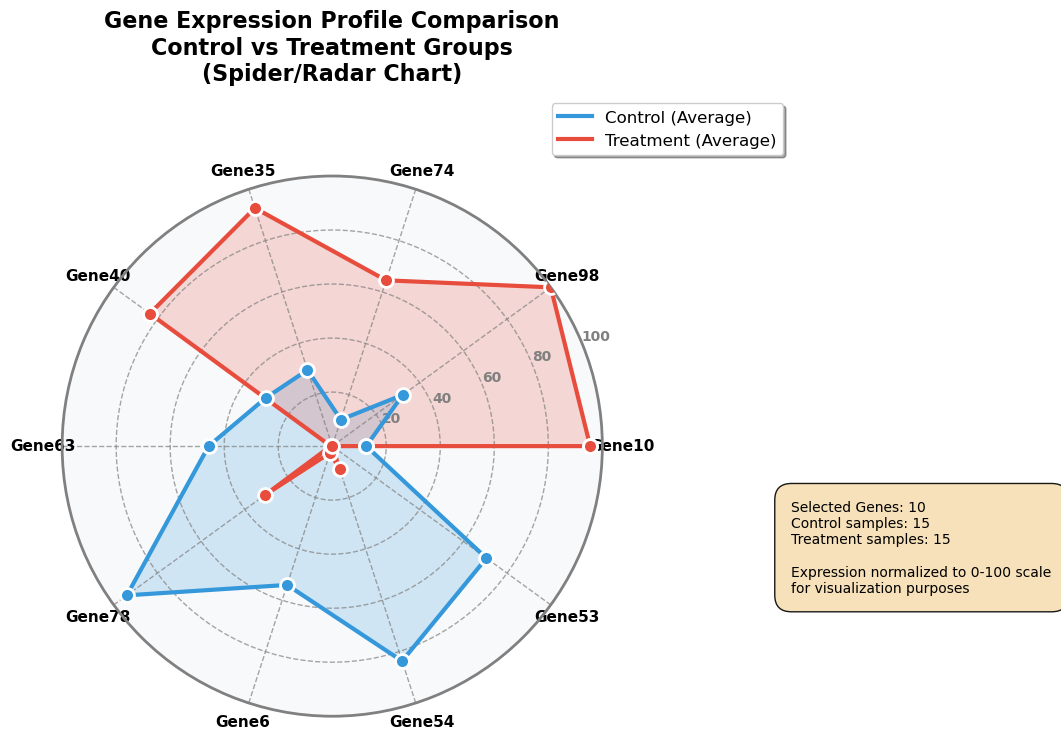


SPIDER CHART GENERATED SUCCESSFULLY!


DETAILED GENE EXPRESSION COMPARISON
  Gene  Control_Mean  Treatment_Mean  Fold_Change Change_Direction
Gene10     40.133333       69.600000     1.734219               Up
Gene98     47.133333       71.200000     1.510608               Up
Gene74     39.333333       58.600000     1.489831               Up
Gene35     46.200000       68.600000     1.484848               Up
Gene40     46.466667       65.333333     1.406026               Up
Gene63     51.933333       35.866667     0.690629             Down
Gene78     69.066667       46.666667     0.675676             Down
 Gene6     54.866667       36.600000     0.667072             Down
Gene54     65.400000       38.800000     0.593272             Down
Gene53     60.733333       35.666667     0.587267             Down

FILES SAVED:
  1. gene_expression_spider_chart.png - Spider chart visualization
  2. spider_chart_gene_comparison.csv - Detailed comparison data


HOW TO INTERPRET THE SPIDER CHART:
• Ea

In [17]:
# ============================================================================
# GENE EXPRESSION SPIDER/RADAR CHART
# ============================================================================
# This script creates a spider chart to visualize gene expression patterns
# comparing Control vs Treatment groups across multiple genes
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# ============================================================================
# STEP 1: LOAD YOUR GENE EXPRESSION DATA
# ============================================================================
# Load your data - replace 'your_gene_data.csv' with your actual file path
# Make sure the CSV has columns: Gene, Control1-9, Treatment6-15
df = pd.read_csv('cancer_expression.csv')

print("Data loaded successfully!")
print(f"Total genes: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

# ============================================================================
# STEP 2: IDENTIFY CONTROL AND TREATMENT COLUMNS
# ============================================================================
# Automatically detect control and treatment columns
control_cols = [col for col in df.columns if 'Control' in col]
treatment_cols = [col for col in df.columns if 'Treatment' in col]

print(f"\nFound {len(control_cols)} control samples")
print(f"Found {len(treatment_cols)} treatment samples")

# ============================================================================
# STEP 3: CALCULATE AVERAGE EXPRESSION FOR EACH GENE
# ============================================================================
# Calculate mean expression across all replicates
df['Control_Mean'] = df[control_cols].mean(axis=1)
df['Treatment_Mean'] = df[treatment_cols].mean(axis=1)

# Calculate fold change (Treatment/Control)
epsilon = 1e-10  # Small value to avoid division by zero
df['Fold_Change'] = (df['Treatment_Mean'] + epsilon) / (df['Control_Mean'] + epsilon)

# ============================================================================
# STEP 4: SELECT TOP DIFFERENTIALLY EXPRESSED GENES
# ============================================================================
# Select genes with highest fold changes (both up and down regulated)
# We'll pick top 5 upregulated and top 5 downregulated genes for the spider chart

# Sort by fold change
df_sorted = df.sort_values('Fold_Change', ascending=False)

# Get top 5 upregulated genes (highest fold change)
top_upregulated = df_sorted.head(5)

# Get top 5 downregulated genes (lowest fold change)
top_downregulated = df_sorted.tail(5)

# Combine them
selected_genes = pd.concat([top_upregulated, top_downregulated])

print(f"\nSelected {len(selected_genes)} genes for spider chart visualization")
print("\nTop Upregulated Genes:")
for idx, row in top_upregulated.iterrows():
    print(f"  {row['Gene']}: {row['Fold_Change']:.2f}x fold change")

print("\nTop Downregulated Genes:")
for idx, row in top_downregulated.iterrows():
    print(f"  {row['Gene']}: {row['Fold_Change']:.2f}x fold change")

# ============================================================================
# STEP 5: PREPARE DATA FOR SPIDER CHART
# ============================================================================
# We'll create a spider chart showing normalized expression patterns
# Each axis = one selected gene
# Two groups: Control (average) vs Treatment (average)

# Extract gene names as categories
categories = selected_genes['Gene'].tolist()
num_vars = len(categories)

# Normalize expression values to 0-100 scale for better visualization
# This makes all genes comparable on the same scale
def normalize_to_scale(values, min_val=0, max_val=100):
    """Normalize values to a 0-100 scale"""
    v_min = values.min()
    v_max = values.max()
    if v_max == v_min:
        return np.full(len(values), 50)  # If all same, return middle value
    normalized = (values - v_min) / (v_max - v_min) * (max_val - min_val) + min_val
    return normalized

# Get control and treatment means for selected genes
control_values = selected_genes['Control_Mean'].values
treatment_values = selected_genes['Treatment_Mean'].values

# Normalize both groups together to maintain relative differences
all_values = np.concatenate([control_values, treatment_values])
normalized_all = normalize_to_scale(all_values)

# Split back into control and treatment
control_normalized = normalized_all[:len(control_values)].tolist()
treatment_normalized = normalized_all[len(control_values):].tolist()

# ============================================================================
# STEP 6: CALCULATE ANGLES FOR SPIDER CHART
# ============================================================================
# Calculate angle for each axis (divide circle into equal parts)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the circle

# Add first value at end to close the circle
control_normalized += control_normalized[:1]
treatment_normalized += treatment_normalized[:1]

# ============================================================================
# STEP 7: CREATE THE SPIDER CHART
# ============================================================================
# Initialize the plot with polar projection
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Define colors
control_color = '#3498DB'    # Blue for control
treatment_color = '#E74C3C'  # Red for treatment

# Plot Control group
ax.plot(angles, control_normalized,
        linewidth=3,
        linestyle='-',
        label='Control (Average)',
        color=control_color)
ax.fill(angles, control_normalized,
        color=control_color,
        alpha=0.2)
ax.scatter(angles, control_normalized,
           color=control_color,
           s=100,
           zorder=5,
           edgecolors='white',
           linewidths=2)

# Plot Treatment group
ax.plot(angles, treatment_normalized,
        linewidth=3,
        linestyle='-',
        label='Treatment (Average)',
        color=treatment_color)
ax.fill(angles, treatment_normalized,
        color=treatment_color,
        alpha=0.2)
ax.scatter(angles, treatment_normalized,
           color=treatment_color,
           s=100,
           zorder=5,
           edgecolors='white',
           linewidths=2)

# ============================================================================
# STEP 8: CUSTOMIZE CHART APPEARANCE
# ============================================================================
# Set category labels (gene names)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11, weight='bold')

# Set radial axis limits and labels
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], 
                    size=10, 
                    color='gray',
                    weight='bold')

# Customize grid
ax.grid(True, linestyle='--', linewidth=1, alpha=0.7, color='gray')
ax.set_facecolor('#F8F9FA')
ax.spines['polar'].set_color('gray')
ax.spines['polar'].set_linewidth(2)

# ============================================================================
# STEP 9: ADD TITLE AND LEGEND
# ============================================================================
plt.title('Gene Expression Profile Comparison\nControl vs Treatment Groups\n(Spider/Radar Chart)', 
          size=16,
          weight='bold',
          pad=30,
          y=1.1)

plt.legend(loc='upper right',
           bbox_to_anchor=(1.35, 1.15),
           fontsize=12,
           frameon=True,
           shadow=True,
           fancybox=True)

# ============================================================================
# STEP 10: ADD INFORMATION BOX
# ============================================================================
# Create information text
info_text = f"Selected Genes: {len(selected_genes)}\n"
info_text += f"Control samples: {len(control_cols)}\n"
info_text += f"Treatment samples: {len(treatment_cols)}\n"
info_text += f"\nExpression normalized to 0-100 scale\n"
info_text += f"for visualization purposes"

plt.text(1.35, 0.4, info_text,
         transform=ax.transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round',
                   facecolor='wheat',
                   alpha=0.9,
                   pad=1.2))

# ============================================================================
# STEP 11: SAVE AND DISPLAY
# ============================================================================
plt.tight_layout()
plt.savefig('gene_expression_spider_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("SPIDER CHART GENERATED SUCCESSFULLY!")
print("="*70)

# ============================================================================
# STEP 12: CREATE DETAILED COMPARISON TABLE
# ============================================================================
print("\n\nDETAILED GENE EXPRESSION COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Gene': selected_genes['Gene'].values,
    'Control_Mean': selected_genes['Control_Mean'].values,
    'Treatment_Mean': selected_genes['Treatment_Mean'].values,
    'Fold_Change': selected_genes['Fold_Change'].values,
    'Change_Direction': ['Up' if fc > 1 else 'Down' 
                         for fc in selected_genes['Fold_Change'].values]
})

print(comparison_df.to_string(index=False))

# ============================================================================
# STEP 13: SAVE RESULTS
# ============================================================================
# Save comparison data to CSV
comparison_df.to_csv('spider_chart_gene_comparison.csv', index=False)

print("\n" + "="*70)
print("FILES SAVED:")
print("  1. gene_expression_spider_chart.png - Spider chart visualization")
print("  2. spider_chart_gene_comparison.csv - Detailed comparison data")
print("="*70)

# ============================================================================
# STEP 14: PRINT INTERPRETATION GUIDE
# ============================================================================
print("\n\nHOW TO INTERPRET THE SPIDER CHART:")
print("="*70)
print("• Each axis represents one gene")
print("• Blue area = Control group expression pattern")
print("• Red area = Treatment group expression pattern")
print("• Larger area = Higher overall expression")
print("• Different shapes indicate different expression profiles")
print("• Points far from center = High expression")
print("• Points near center = Low expression")
print("\nKey Insights:")
print("• Where red exceeds blue = Gene upregulated in treatment")
print("• Where blue exceeds red = Gene downregulated in treatment")
print("• Similar shapes = Similar expression patterns")
print("="*70)

# ============================================================================
# END OF SCRIPT
# ============================================================================

GENE EXPRESSION DATA LOADED
Total genes: 100
Columns found: 31

Control samples: 15
Treatment samples: 15

Statistical analysis completed!

GENE SETS DEFINED
Upregulated         :    0 genes
Downregulated       :    0 genes
High in Control     :   20 genes
High in Treatment   :   20 genes
Low Expression      :    2 genes

Found 5 unique intersections


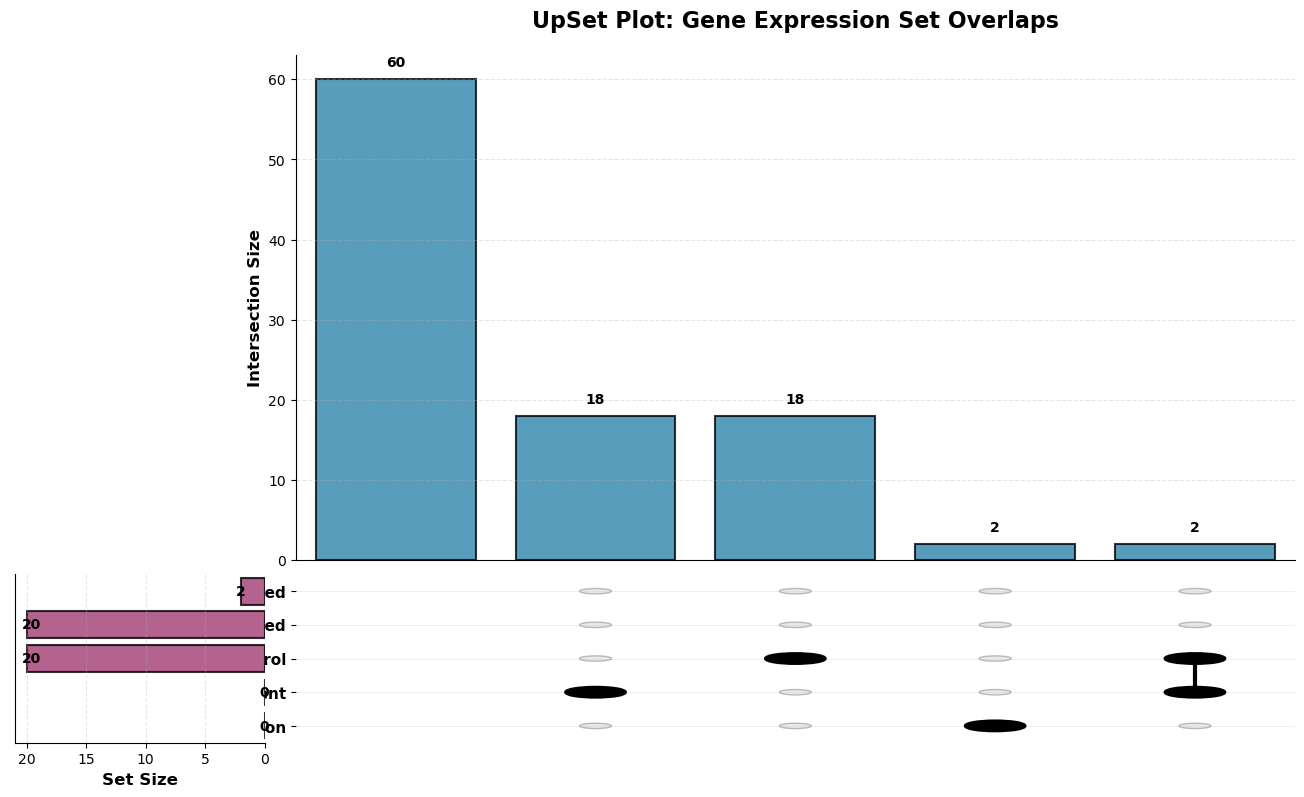


UPSET PLOT GENERATED SUCCESSFULLY!


TOP 10 GENE INTERSECTIONS:

1. Intersection Size: 60 genes
   Sets involved: 
   Sample genes: Gene3, Gene4, Gene5, Gene6, Gene7 ...

2. Intersection Size: 18 genes
   Sets involved: High in Treatment
   Sample genes: Gene2, Gene10, Gene16, Gene25, Gene32 ...

3. Intersection Size: 18 genes
   Sets involved: High in Control
   Sample genes: Gene8, Gene9, Gene17, Gene27, Gene28 ...

4. Intersection Size: 2 genes
   Sets involved: Low Expression
   Genes: Gene21, Gene80

5. Intersection Size: 2 genes
   Sets involved: High in Control, High in Treatment
   Genes: Gene1, Gene88

FILES SAVED:
  1. gene_expression_upset_plot.png - UpSet plot visualization
  2. upset_plot_intersections.csv - Detailed intersection data
  3. gene_set_membership.csv - Complete membership matrix


HOW TO INTERPRET THE UPSET PLOT:
• TOP BARS: Show how many genes are in each intersection
• CONNECTION DOTS: Black dots show which sets are combined
• VERTICAL LINES: Connect the se

In [21]:
# ============================================================================
# UPSET PLOT FOR GENE EXPRESSION DATA
# ============================================================================
# UpSet plots are an advanced alternative to Venn diagrams for visualizing
# set intersections. They show how many genes are shared between different
# categories (e.g., upregulated, downregulated, highly expressed, etc.)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import stats

# ============================================================================
# STEP 1: LOAD YOUR GENE EXPRESSION DATA
# ============================================================================
# Load your data - replace 'your_gene_data.csv' with your actual file path
df = pd.read_csv('cancer_expression.csv')

print("="*70)
print("GENE EXPRESSION DATA LOADED")
print("="*70)
print(f"Total genes: {len(df)}")
print(f"Columns found: {len(df.columns)}")

# ============================================================================
# STEP 2: IDENTIFY CONTROL AND TREATMENT COLUMNS
# ============================================================================
control_cols = [col for col in df.columns if 'Control' in col]
treatment_cols = [col for col in df.columns if 'Treatment' in col]

print(f"\nControl samples: {len(control_cols)}")
print(f"Treatment samples: {len(treatment_cols)}")

# ============================================================================
# STEP 3: CALCULATE STATISTICS FOR EACH GENE
# ============================================================================
# Calculate mean expression
df['Control_Mean'] = df[control_cols].mean(axis=1)
df['Treatment_Mean'] = df[treatment_cols].mean(axis=1)

# Calculate log2 fold change
epsilon = 1e-10
df['Log2FC'] = np.log2((df['Treatment_Mean'] + epsilon) / (df['Control_Mean'] + epsilon))

# Perform t-test for each gene
p_values = []
for idx, row in df.iterrows():
    control_vals = row[control_cols].values.astype(float)
    treatment_vals = row[treatment_cols].values.astype(float)
    t_stat, p_val = stats.ttest_ind(treatment_vals, control_vals)
    p_values.append(p_val)

df['P_value'] = p_values

print("\nStatistical analysis completed!")

# ============================================================================
# STEP 4: DEFINE GENE SETS BASED ON DIFFERENT CRITERIA
# ============================================================================
# We'll create multiple sets of genes based on different biological criteria:
# 1. Significantly Upregulated (Log2FC > 1 and p < 0.05)
# 2. Significantly Downregulated (Log2FC < -1 and p < 0.05)
# 3. Highly Expressed in Control (top 20%)
# 4. Highly Expressed in Treatment (top 20%)
# 5. Low Expression in Both (bottom 20% in both)

# Set 1: Significantly Upregulated
upregulated = set(df[(df['Log2FC'] > 1) & (df['P_value'] < 0.05)]['Gene'].values)

# Set 2: Significantly Downregulated
downregulated = set(df[(df['Log2FC'] < -1) & (df['P_value'] < 0.05)]['Gene'].values)

# Set 3: Highly Expressed in Control (top 20%)
control_threshold = df['Control_Mean'].quantile(0.80)
high_control = set(df[df['Control_Mean'] > control_threshold]['Gene'].values)

# Set 4: Highly Expressed in Treatment (top 20%)
treatment_threshold = df['Treatment_Mean'].quantile(0.80)
high_treatment = set(df[df['Treatment_Mean'] > treatment_threshold]['Gene'].values)

# Set 5: Low Expression in Both (bottom 20%)
low_threshold = min(df['Control_Mean'].quantile(0.20), df['Treatment_Mean'].quantile(0.20))
low_both = set(df[(df['Control_Mean'] < low_threshold) & 
                   (df['Treatment_Mean'] < low_threshold)]['Gene'].values)

# Store all sets
gene_sets = {
    'Upregulated': upregulated,
    'Downregulated': downregulated,
    'High in Control': high_control,
    'High in Treatment': high_treatment,
    'Low Expression': low_both
}

print("\n" + "="*70)
print("GENE SETS DEFINED")
print("="*70)
for set_name, genes in gene_sets.items():
    print(f"{set_name:20s}: {len(genes):4d} genes")

# ============================================================================
# STEP 5: GENERATE ALL POSSIBLE INTERSECTIONS
# ============================================================================
# Create a binary matrix where each row is a gene and each column is a set
# 1 means the gene belongs to that set, 0 means it doesn't

set_names = list(gene_sets.keys())
all_genes = df['Gene'].values

# Create membership matrix
membership_matrix = pd.DataFrame(index=all_genes, columns=set_names)

for gene in all_genes:
    for set_name in set_names:
        membership_matrix.loc[gene, set_name] = 1 if gene in gene_sets[set_name] else 0

# Convert to integers
membership_matrix = membership_matrix.astype(int)

# Group by unique combinations (intersections)
intersections = membership_matrix.groupby(set_names).size().reset_index(name='count')

# Sort by count (descending)
intersections = intersections.sort_values('count', ascending=False)

# Keep only intersections with at least 1 gene
intersections = intersections[intersections['count'] > 0]

print(f"\nFound {len(intersections)} unique intersections")

# ============================================================================
# STEP 6: CREATE UPSET PLOT
# ============================================================================
# UpSet plot consists of:
# 1. Top: Bar chart showing intersection sizes
# 2. Bottom: Matrix showing which sets are in each intersection
# 3. Left: Bar chart showing total set sizes

fig = plt.figure(figsize=(16, 10))

# Define layout
gs = fig.add_gridspec(3, 2, width_ratios=[1, 4], height_ratios=[3, 1, 1],
                      hspace=0.05, wspace=0.05)

# Top plot: Intersection sizes (bar chart)
ax_bars = fig.add_subplot(gs[0, 1])
# Bottom plot: Connection matrix
ax_matrix = fig.add_subplot(gs[1, 1], sharex=ax_bars)
# Set size bars (left side)
ax_setsize = fig.add_subplot(gs[1, 0])

# Limit to top 20 intersections for clarity
top_intersections = intersections.head(20)

# ============================================================================
# STEP 7: PLOT INTERSECTION SIZES (TOP BAR CHART)
# ============================================================================
x_positions = range(len(top_intersections))
counts = top_intersections['count'].values

# Create bars
bars = ax_bars.bar(x_positions, counts, 
                   color='#2E86AB', 
                   edgecolor='black', 
                   linewidth=1.5,
                   alpha=0.8)

# Add count labels on bars
for i, (x, count) in enumerate(zip(x_positions, counts)):
    ax_bars.text(x, count + max(counts)*0.02, str(count),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax_bars.set_ylabel('Intersection Size', fontsize=12, fontweight='bold')
ax_bars.set_title('UpSet Plot: Gene Expression Set Overlaps', 
                  fontsize=16, fontweight='bold', pad=20)
ax_bars.spines['top'].set_visible(False)
ax_bars.spines['right'].set_visible(False)
ax_bars.grid(axis='y', alpha=0.3, linestyle='--')
ax_bars.set_xlim(-0.5, len(top_intersections)-0.5)

# Remove x-axis labels
ax_bars.set_xticks([])

# ============================================================================
# STEP 8: PLOT CONNECTION MATRIX (BOTTOM)
# ============================================================================
# This shows which sets are included in each intersection

# Draw horizontal lines for each set
y_positions = {set_name: i for i, set_name in enumerate(set_names)}

# Set up matrix plot
ax_matrix.set_ylim(-0.5, len(set_names)-0.5)
ax_matrix.set_xlim(-0.5, len(top_intersections)-0.5)

# Draw grid lines
for y in range(len(set_names)):
    ax_matrix.axhline(y, color='lightgray', linewidth=0.5, alpha=0.5)

# For each intersection, draw the connection pattern
for i, (idx, row) in enumerate(top_intersections.iterrows()):
    # Find which sets are active (value = 1)
    active_sets = [set_name for set_name in set_names if row[set_name] == 1]
    
    if len(active_sets) > 0:
        # Get y positions of active sets
        y_vals = [y_positions[s] for s in active_sets]
        
        # Draw vertical line connecting active sets
        if len(y_vals) > 1:
            ax_matrix.plot([i, i], [min(y_vals), max(y_vals)], 
                          color='black', linewidth=3, solid_capstyle='round')
        
        # Draw dots for each active set
        for y in y_vals:
            circle = patches.Circle((i, y), radius=0.15, 
                                   facecolor='black', 
                                   edgecolor='black', 
                                   linewidth=2,
                                   zorder=10)
            ax_matrix.add_patch(circle)
        
        # Draw empty dots for inactive sets
        for set_name in set_names:
            if set_name not in active_sets:
                y = y_positions[set_name]
                circle = patches.Circle((i, y), radius=0.08, 
                                       facecolor='lightgray', 
                                       edgecolor='gray',
                                       linewidth=1,
                                       alpha=0.5,
                                       zorder=5)
                ax_matrix.add_patch(circle)

# Set y-axis labels (set names)
ax_matrix.set_yticks(range(len(set_names)))
ax_matrix.set_yticklabels(set_names, fontsize=11, fontweight='bold')
ax_matrix.set_xticks([])
ax_matrix.invert_yaxis()

# Remove spines
for spine in ax_matrix.spines.values():
    spine.set_visible(False)

# ============================================================================
# STEP 9: PLOT SET SIZES (LEFT BAR CHART)
# ============================================================================
# Show total size of each set

set_sizes = [len(gene_sets[name]) for name in set_names]
y_pos = range(len(set_names))

bars_left = ax_setsize.barh(y_pos, set_sizes, 
                            color='#A23B72', 
                            edgecolor='black',
                            linewidth=1.5,
                            alpha=0.8)

# Add count labels
for i, size in enumerate(set_sizes):
    ax_setsize.text(size + max(set_sizes)*0.02, i, str(size),
                   va='center', ha='left', fontsize=10, fontweight='bold')

ax_setsize.set_xlabel('Set Size', fontsize=12, fontweight='bold')
ax_setsize.set_yticks([])
ax_setsize.invert_xaxis()
ax_setsize.invert_yaxis()
ax_setsize.spines['top'].set_visible(False)
ax_setsize.spines['right'].set_visible(False)
ax_setsize.grid(axis='x', alpha=0.3, linestyle='--')
ax_setsize.set_ylim(-0.5, len(set_names)-0.5)

# ============================================================================
# STEP 10: SAVE AND DISPLAY
# ============================================================================
# Adjust spacing manually instead of tight_layout to avoid warning
plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.05, hspace=0.05, wspace=0.05)
plt.savefig('gene_expression_upset_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("UPSET PLOT GENERATED SUCCESSFULLY!")
print("="*70)

# ============================================================================
# STEP 11: DETAILED INTERSECTION ANALYSIS
# ============================================================================
print("\n\nTOP 10 GENE INTERSECTIONS:")
print("="*70)

for i, (idx, row) in enumerate(top_intersections.head(10).iterrows(), 1):
    active_sets = [set_name for set_name in set_names if row[set_name] == 1]
    count = row['count']
    
    print(f"\n{i}. Intersection Size: {count} genes")
    print(f"   Sets involved: {', '.join(active_sets)}")
    
    # Find actual genes in this intersection
    mask = membership_matrix[set_names].eq(row[set_names]).all(axis=1)
    genes_in_intersection = membership_matrix[mask].index.tolist()
    
    if len(genes_in_intersection) <= 5:
        print(f"   Genes: {', '.join(genes_in_intersection)}")
    else:
        print(f"   Sample genes: {', '.join(genes_in_intersection[:5])} ...")

# ============================================================================
# STEP 12: SAVE DETAILED RESULTS
# ============================================================================
# Save intersection data
intersection_details = []

for idx, row in top_intersections.iterrows():
    active_sets = [set_name for set_name in set_names if row[set_name] == 1]
    mask = membership_matrix[set_names].eq(row[set_names]).all(axis=1)
    genes = membership_matrix[mask].index.tolist()
    
    intersection_details.append({
        'Sets': ' & '.join(active_sets),
        'Count': row['count'],
        'Genes': '; '.join(genes)
    })

detail_df = pd.DataFrame(intersection_details)
detail_df.to_csv('upset_plot_intersections.csv', index=False)

# Save membership matrix
membership_matrix.to_csv('gene_set_membership.csv')

print("\n" + "="*70)
print("FILES SAVED:")
print("  1. gene_expression_upset_plot.png - UpSet plot visualization")
print("  2. upset_plot_intersections.csv - Detailed intersection data")
print("  3. gene_set_membership.csv - Complete membership matrix")
print("="*70)

# ============================================================================
# STEP 13: INTERPRETATION GUIDE
# ============================================================================
print("\n\nHOW TO INTERPRET THE UPSET PLOT:")
print("="*70)
print("• TOP BARS: Show how many genes are in each intersection")
print("• CONNECTION DOTS: Black dots show which sets are combined")
print("• VERTICAL LINES: Connect the sets that form an intersection")
print("• LEFT BARS: Show total size of each individual set")
print("\nKey Insights:")
print("• Single dot = Genes unique to one set")
print("• Multiple connected dots = Genes shared between sets")
print("• Tallest bars = Most common gene combinations")
print("• Look for unexpected overlaps between sets")
print("="*70)

# ============================================================================
# END OF SCRIPT
# ============================================================================
# UpSet plots are superior to Venn diagrams when:
# - Comparing more than 3 sets
# - Visualizing complex intersections
# - Quantifying exact intersection sizes
# - Identifying patterns in set overlaps
# ============================================================================

In [24]:
%pip install upsetplot matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

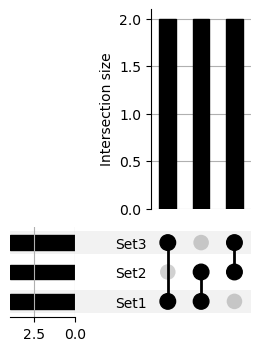

In [1]:
import pandas as pd
from upsetplot import UpSet

# Sample DataFrame
df = pd.DataFrame({
    'item': ['A', 'B', 'C', 'D', 'E', 'F'],
    'Set1': [True, True, False, True, False, True],
    'Set2': [False, True, True, True, True, False],
    'Set3': [True, False, True, False, True, True]
}).set_index(['Set1', 'Set2', 'Set3'])

# Create and display the UpSet plot
upset = UpSet(df, subset_size='count', sort_by='cardinality')
upset.plot()

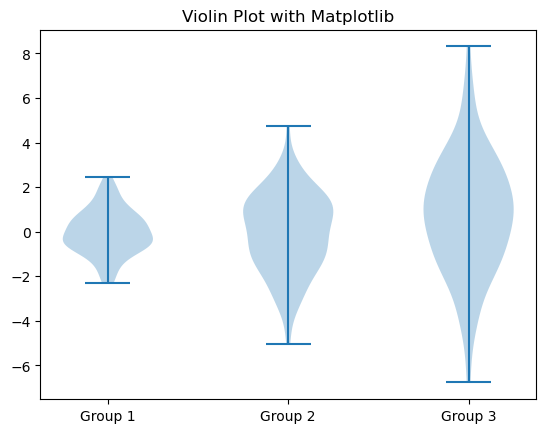

In [2]:
    import matplotlib.pyplot as plt
    import numpy as np

    # Generate some sample data
    data = [np.random.normal(0, std, 100) for std in range(1, 4)]

    # Create a violin plot
    plt.violinplot(data)
    plt.title("Violin Plot with Matplotlib")
    plt.xticks([1, 2, 3], ['Group 1', 'Group 2', 'Group 3'])
    plt.show()

GENE EXPRESSION DATA LOADED
Total genes: 100
Total columns: 31

Control samples: 15
Treatment samples: 15

Total data points for visualization: 3000
  Control data points: 1500
  Treatment data points: 1500

SUMMARY STATISTICS

Control Group:
  Mean      : 52.01
  Median    : 52.50
  Std Dev   : 27.87
  Min       : 5.00
  Max       : 99.00
  Q1        : 28.00
  Q3        : 76.00

Treatment Group:
  Mean      : 51.29
  Median    : 51.00
  Std Dev   : 26.93
  Min       : 5.00
  Max       : 99.00
  Q1        : 28.00
  Q3        : 74.00

Statistical Test (t-test):
  t-statistic: 0.7272
  p-value: 4.6713e-01
  Significance: ns (p >= 0.05) - Not significant


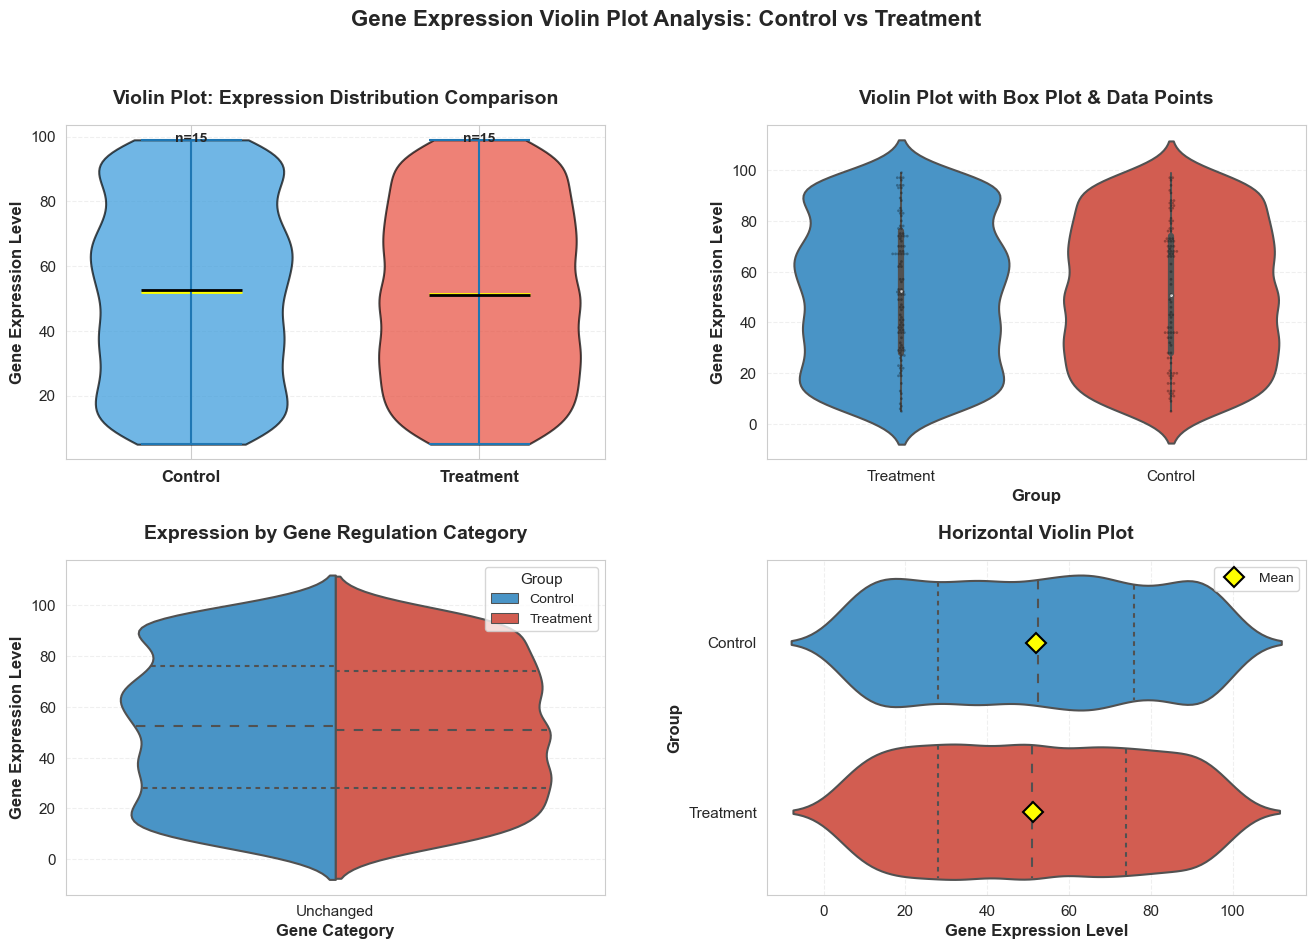


VIOLIN PLOTS GENERATED SUCCESSFULLY!


Top 10 Differentially Expressed Genes:
Gene10          | Fold Change:   1.73x
Gene53          | Fold Change:   0.59x
Gene54          | Fold Change:   0.59x
Gene98          | Fold Change:   1.51x
Gene6           | Fold Change:   0.67x
Gene74          | Fold Change:   1.49x
Gene35          | Fold Change:   1.48x
Gene78          | Fold Change:   0.68x
Gene63          | Fold Change:   0.69x
Gene92          | Fold Change:   0.69x


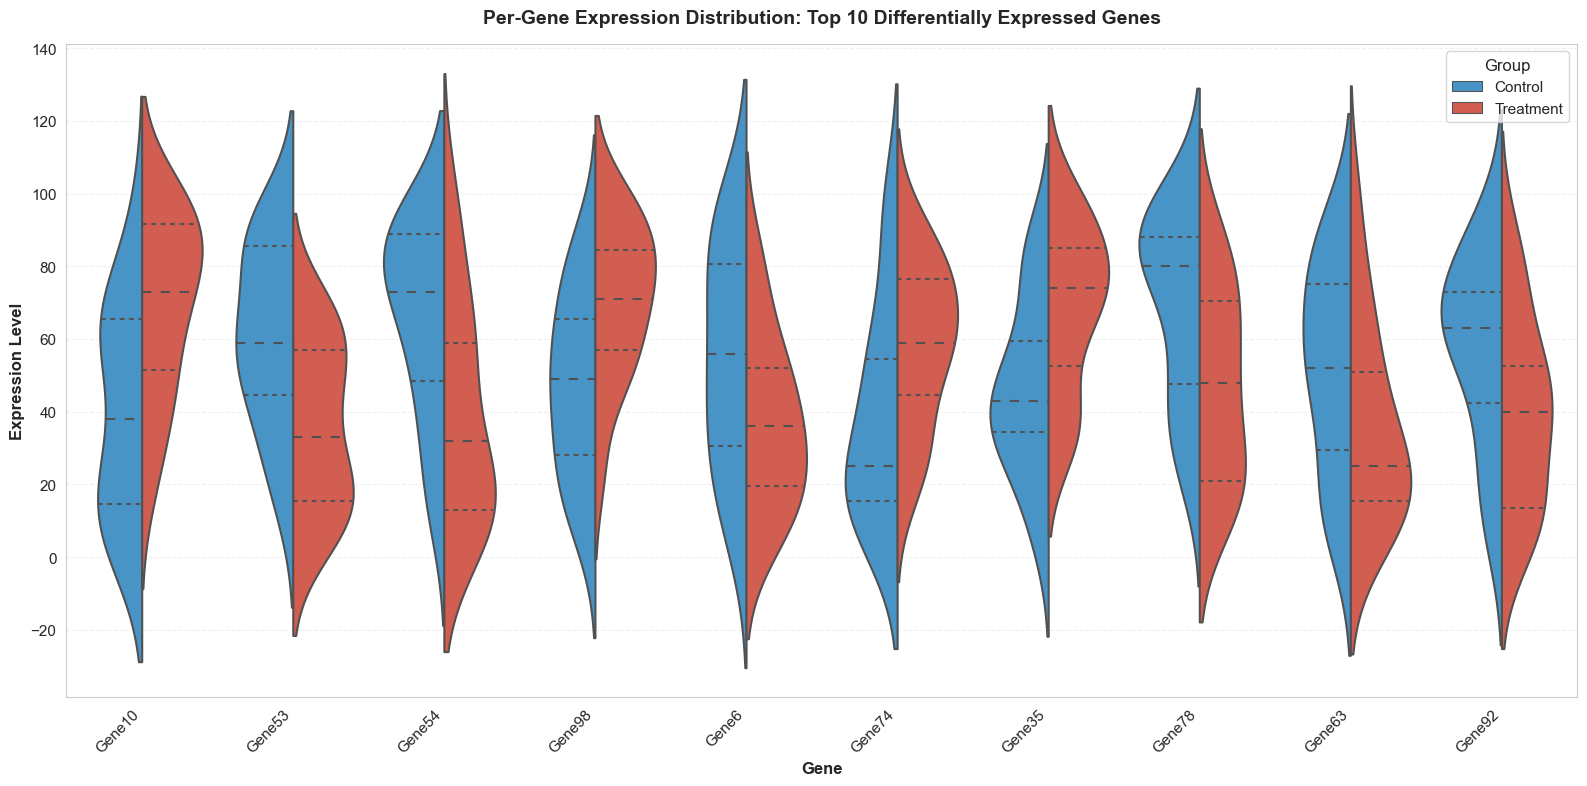


FILES SAVED:
  1. gene_expression_violin_plot.png - Comprehensive violin plots
  2. per_gene_violin_plot.png - Top 10 genes violin plot
  3. violin_plot_statistics.csv - Statistical summary


HOW TO INTERPRET VIOLIN PLOTS:
• WIDTH: Shows the density of data at different values
  - Wider = More genes with that expression level
  - Narrow = Fewer genes with that expression level

• SHAPE:
  - Single peak = Unimodal distribution (most common)
  - Multiple peaks = Bimodal/multimodal (subpopulations)
  - Symmetric = Normal distribution
  - Asymmetric = Skewed distribution

• INTERNAL LINES:
  - Black line = Median (50th percentile)
  - Yellow line = Mean (average)
  - Box = Interquartile range (25th-75th percentile)

• COMPARISON:
  - Overlapping shapes = Similar distributions
  - Separated shapes = Different distributions
  - Compare medians and spreads between groups


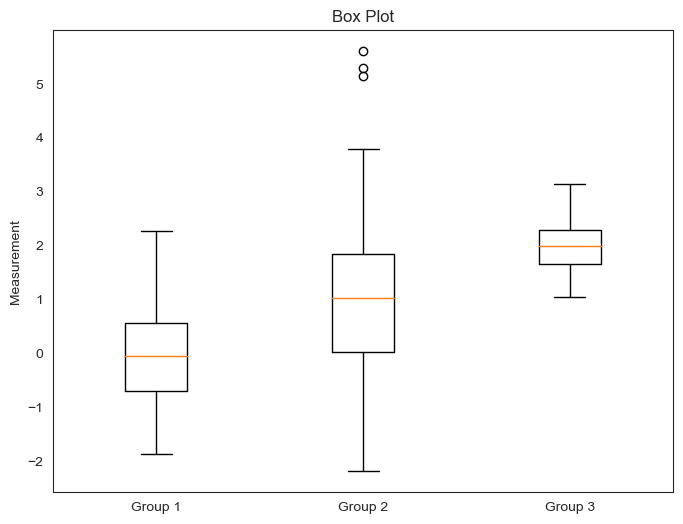

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic biological measurements
data = [np.random.normal(0, 1, 100), np.random.normal(1, 1.5, 100), np.random.normal(2, 0.5, 100)]

# Plot
plt.figure(figsize=(8, 6))
plt.boxplot(data)
plt.xticks([1, 2, 3], ['Group 1', 'Group 2', 'Group 3'])
plt.title('Box Plot')
plt.ylabel('Measurement')
plt.show()

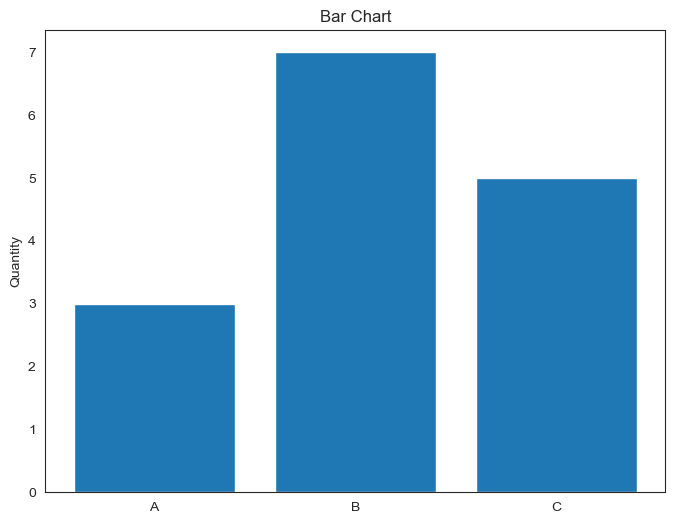

In [10]:
import matplotlib.pyplot as plt

# Synthetic categorical data
categories = ['A', 'B', 'C']
values = [3, 7, 5]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.title('Bar Chart')
plt.ylabel('Quantity')
plt.show()

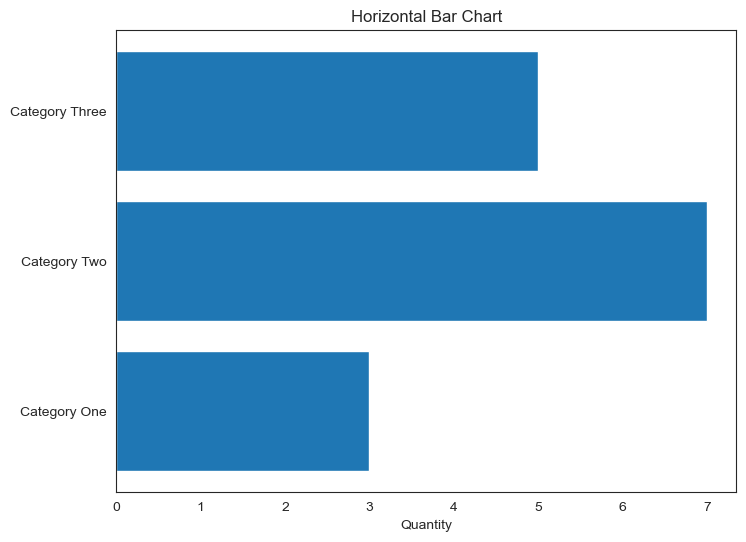

In [11]:
import matplotlib.pyplot as plt

# Synthetic data with long labels
categories = ['Category One', 'Category Two', 'Category Three']
values = [3, 7, 5]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(categories, values)
plt.title('Horizontal Bar Chart')
plt.xlabel('Quantity')
plt.show()

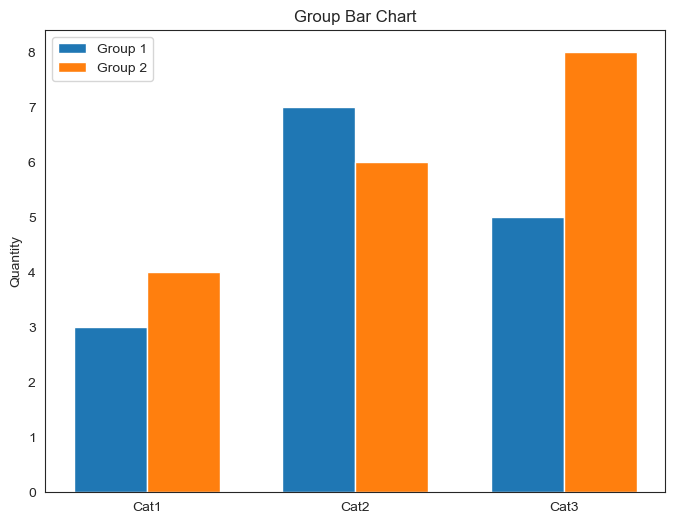

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic subgroup data
categories = ['Cat1', 'Cat2', 'Cat3']
group1 = [3, 7, 5]
group2 = [4, 6, 8]
x = np.arange(len(categories))
width = 0.35

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, group1, width, label='Group 1')
plt.bar(x + width/2, group2, width, label='Group 2')
plt.xticks(x, categories)
plt.title('Group Bar Chart')
plt.ylabel('Quantity')
plt.legend()
plt.show()

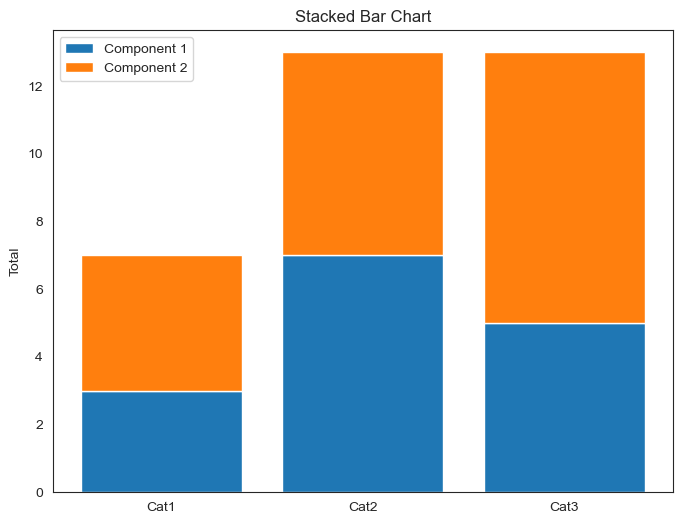

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic composition data
categories = ['Cat1', 'Cat2', 'Cat3']
component1 = [3, 7, 5]
component2 = [4, 6, 8]
x = np.arange(len(categories))

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, component1, label='Component 1')
plt.bar(x, component2, bottom=component1, label='Component 2')
plt.xticks(x, categories)
plt.title('Stacked Bar Chart')
plt.ylabel('Total')
plt.legend()
plt.show()

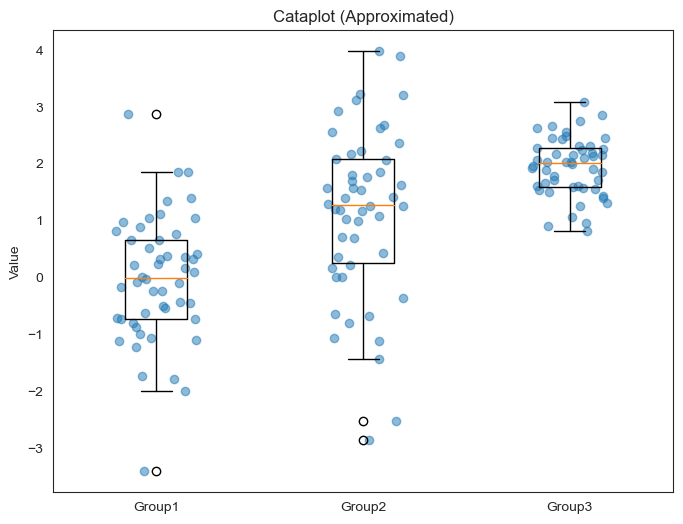

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic categorical data (approximate catplot with jittered scatter + box)
categories = ['Group1']*50 + ['Group2']*50 + ['Group3']*50
values = np.concatenate([np.random.normal(0, 1, 50), np.random.normal(1, 1.5, 50), np.random.normal(2, 0.5, 50)])
x = [1]*50 + [2]*50 + [3]*50
jitter = np.random.uniform(-0.2, 0.2, len(values))
x_jitter = np.array(x) + jitter

# Plot scatter and box
plt.figure(figsize=(8, 6))
plt.scatter(x_jitter, values, alpha=0.5)
plt.boxplot([values[:50], values[50:100], values[100:]], positions=[1,2,3], widths=0.3)
plt.xticks([1,2,3], ['Group1', 'Group2', 'Group3'])
plt.title('Cataplot (Approximated)')
plt.ylabel('Value')
plt.show()

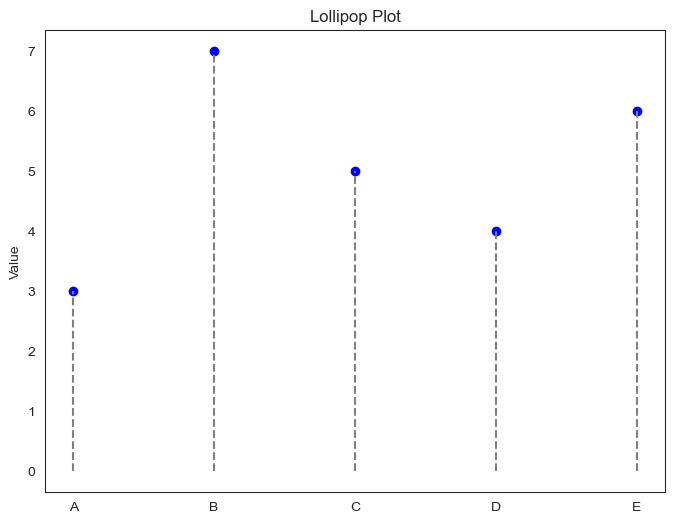

In [15]:
import matplotlib.pyplot as plt

# Synthetic category values
categories = ['A', 'B', 'C', 'D', 'E']
values = [3, 7, 5, 4, 6]

# Plot
plt.figure(figsize=(8, 6))
plt.vlines(range(len(values)), 0, values, color='grey', linestyle='--')
plt.scatter(range(len(values)), values, color='blue')
plt.xticks(range(len(values)), categories)
plt.title('Lollipop Plot')
plt.ylabel('Value')
plt.show()

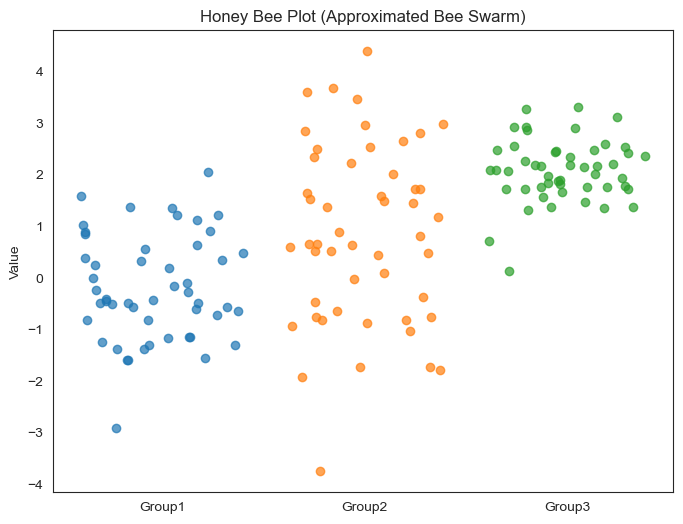

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic group distributions (approximate swarm with jitter)
groups = ['Group1', 'Group2', 'Group3']
data = [np.random.normal(0, 1, 50), np.random.normal(1, 1.5, 50), np.random.normal(2, 0.5, 50)]

# Plot with horizontal jitter
plt.figure(figsize=(8, 6))
for i, d in enumerate(data, 1):
    x = np.full(len(d), i) + np.random.uniform(-0.4, 0.4, len(d))
    plt.scatter(x, d, alpha=0.7)
plt.xticks([1,2,3], groups)
plt.title('Honey Bee Plot (Approximated Bee Swarm)')
plt.ylabel('Value')
plt.show()

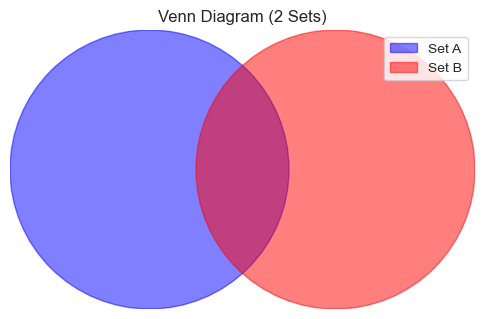

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Synthetic set overlaps (simple 2-set Venn)
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(Circle((0.3, 0.3), 0.3, alpha=0.5, color='blue', label='Set A'))
ax.add_patch(Circle((0.7, 0.3), 0.3, alpha=0.5, color='red', label='Set B'))
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.6)
ax.set_aspect('equal')
ax.axis('off')
plt.title('Venn Diagram (2 Sets)')
plt.legend()
plt.show()

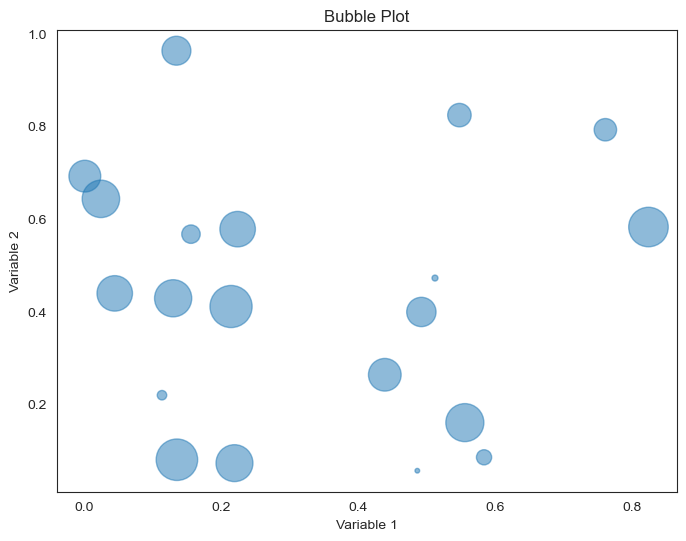

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic multi-dimensional data
x = np.random.rand(20)
y = np.random.rand(20)
sizes = np.random.rand(20) * 1000

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=sizes, alpha=0.5)
plt.title('Bubble Plot')
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.show()

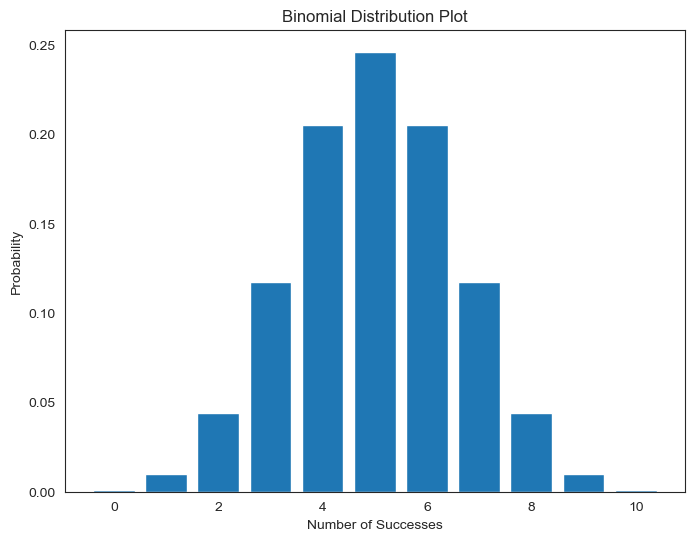

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Parameters for binomial
n, p = 10, 0.5
x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, pmf)
plt.title('Binomial Distribution Plot')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.show()

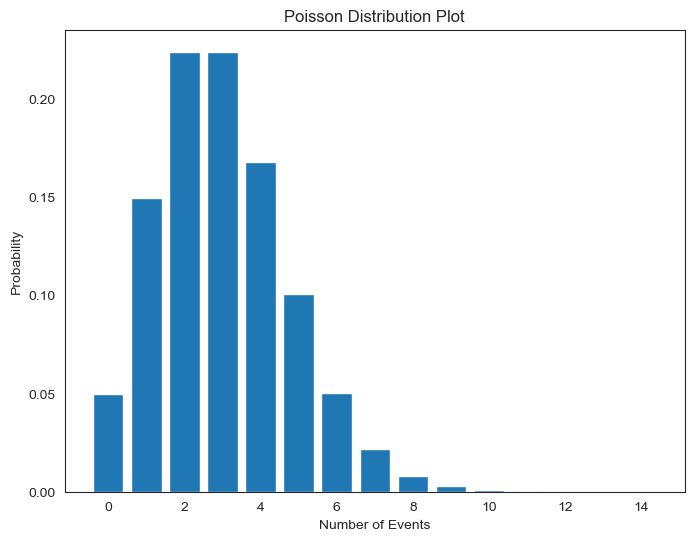

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameter for Poisson
mu = 3
x = np.arange(0, 15)
pmf = poisson.pmf(x, mu)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, pmf)
plt.title('Poisson Distribution Plot')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.show()

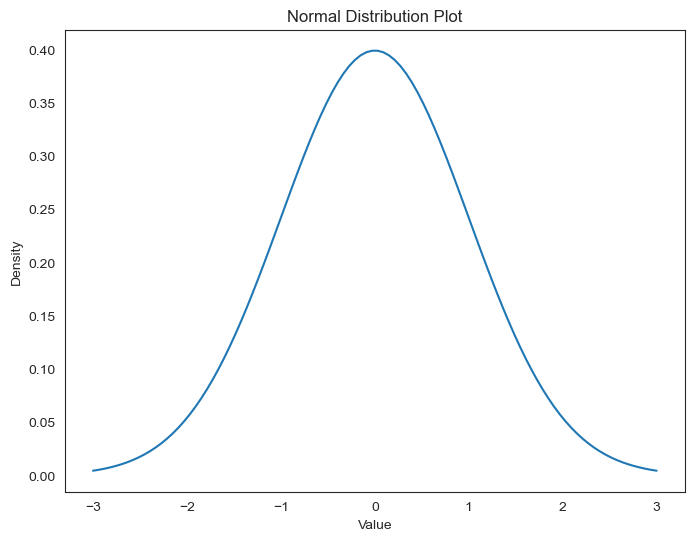

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for normal
mu, sigma = 0, 1
x = np.linspace(-3, 3, 100)
pdf = norm.pdf(x, mu, sigma)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, pdf)
plt.title('Normal Distribution Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

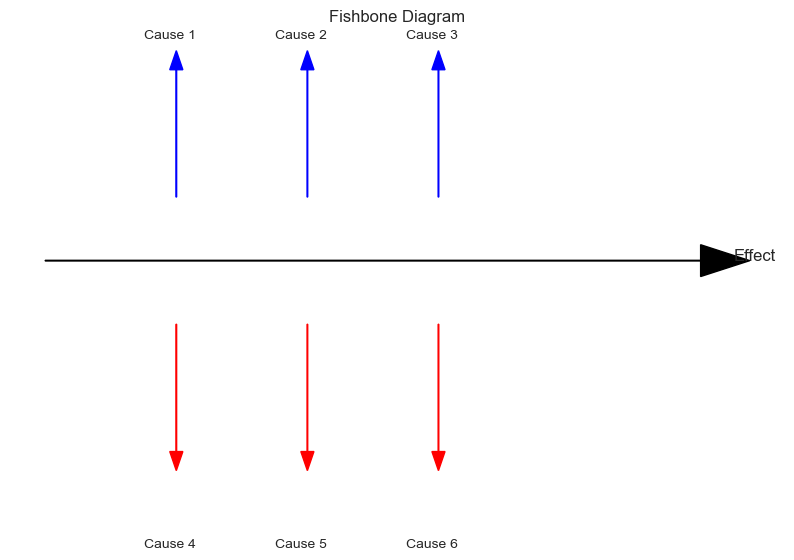

In [22]:
import matplotlib.pyplot as plt

# Simple cause-effect structure
plt.figure(figsize=(10, 6))
# Main line
plt.arrow(0, 0, 1, 0, head_width=0.05, color='black')
# Branches
plt.arrow(0.2, 0.1, 0, 0.2, head_width=0.02, color='blue')
plt.arrow(0.4, 0.1, 0, 0.2, head_width=0.02, color='blue')
plt.arrow(0.6, 0.1, 0, 0.2, head_width=0.02, color='blue')
plt.arrow(0.2, -0.1, 0, -0.2, head_width=0.02, color='red')
plt.arrow(0.4, -0.1, 0, -0.2, head_width=0.02, color='red')
plt.arrow(0.6, -0.1, 0, -0.2, head_width=0.02, color='red')
# Labels
plt.text(1.05, 0, 'Effect', fontsize=12)
plt.text(0.15, 0.35, 'Cause 1', fontsize=10)
plt.text(0.35, 0.35, 'Cause 2', fontsize=10)
plt.text(0.55, 0.35, 'Cause 3', fontsize=10)
plt.text(0.15, -0.45, 'Cause 4', fontsize=10)
plt.text(0.35, -0.45, 'Cause 5', fontsize=10)
plt.text(0.55, -0.45, 'Cause 6', fontsize=10)
plt.axis('off')
plt.title('Fishbone Diagram')
plt.show()

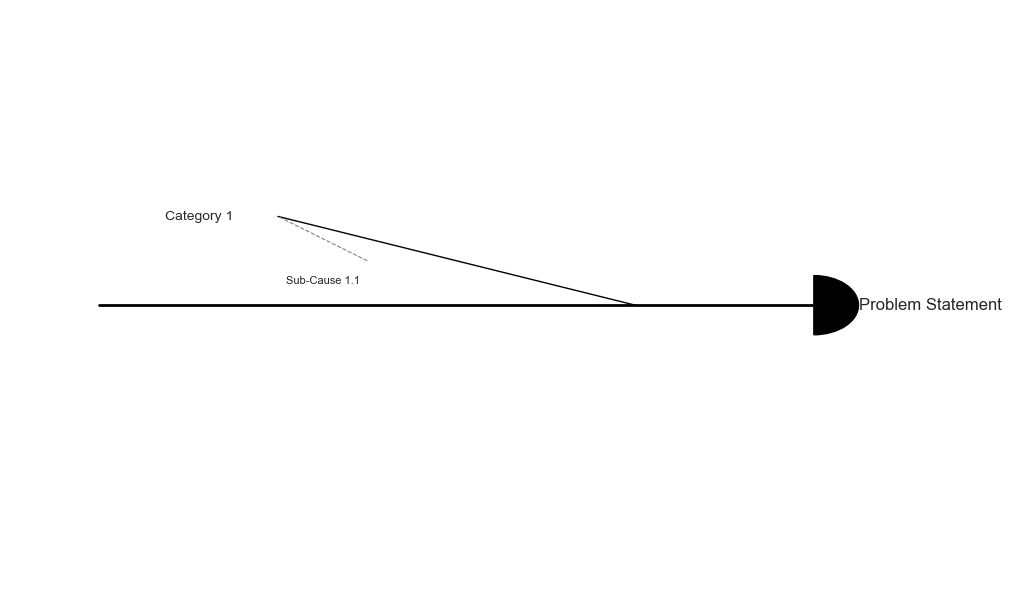

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Wedge

fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

# Example of drawing the spine and head (problem)
ax.plot([-4, 4], [0, 0], color='black', linewidth=2) # Main spine
head = Wedge((4, 0), 0.5, -90, 90, color='black') # Head of the fish
ax.add_patch(head)
ax.text(4.5, 0, 'Problem Statement', ha='left', va='center', fontsize=12)

# Example of drawing a major cause category
ax.plot([-2, 2], [1.5, 0], color='black', linewidth=1) # Bone
ax.text(-2.5, 1.5, 'Category 1', ha='right', va='center', fontsize=10)

# Example of drawing a sub-cause
ax.plot([-1, -2], [0.75, 1.5], color='grey', linestyle='--', linewidth=0.8) # Sub-bone
ax.text(-1.5, 0.5, 'Sub-Cause 1.1', ha='center', va='top', fontsize=8)

plt.show()

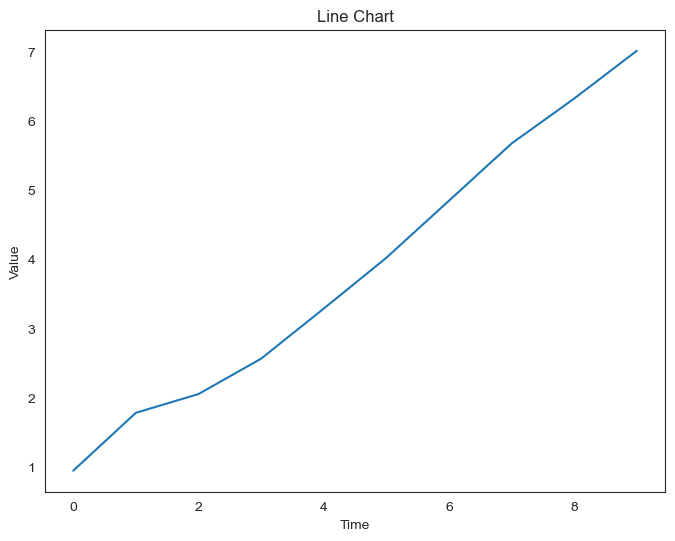

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic time-series data
x = np.arange(10)
y = np.random.rand(10).cumsum()

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Line Chart')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

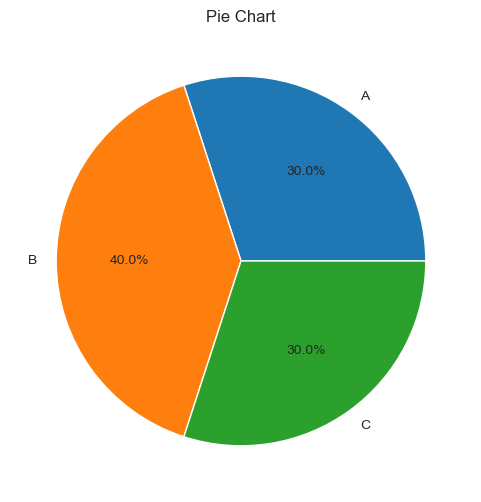

In [24]:
import matplotlib.pyplot as plt

# Synthetic proportions
labels = ['A', 'B', 'C']
sizes = [30, 40, 30]

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart')
plt.show()

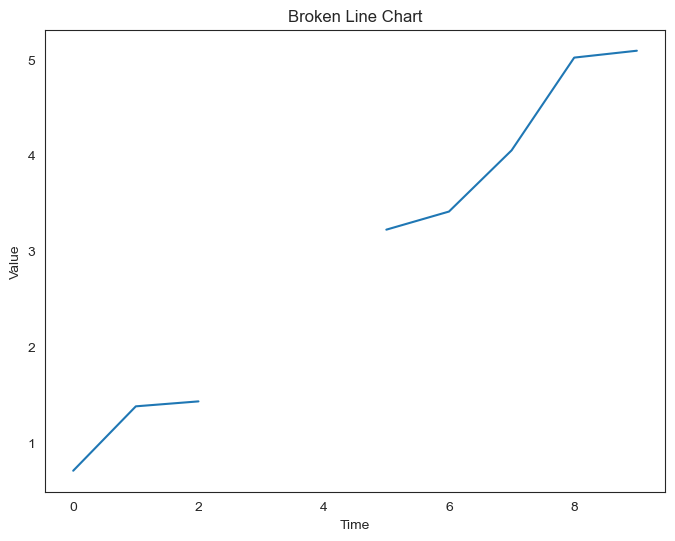

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic data with missing points
x = np.arange(10)
y = np.random.rand(10).cumsum()
y[3:5] = np.nan  # Introduce break

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Broken Line Chart')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

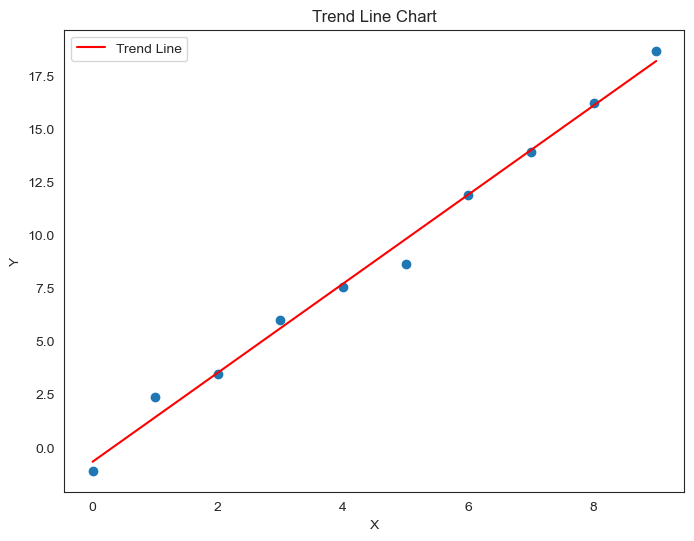

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Synthetic data
x = np.arange(10)
y = 2 * x + np.random.normal(0, 1, 10)
slope, intercept, _, _, _ = linregress(x, y)
trend = slope * x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.plot(x, trend, color='red', label='Trend Line')
plt.title('Trend Line Chart')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

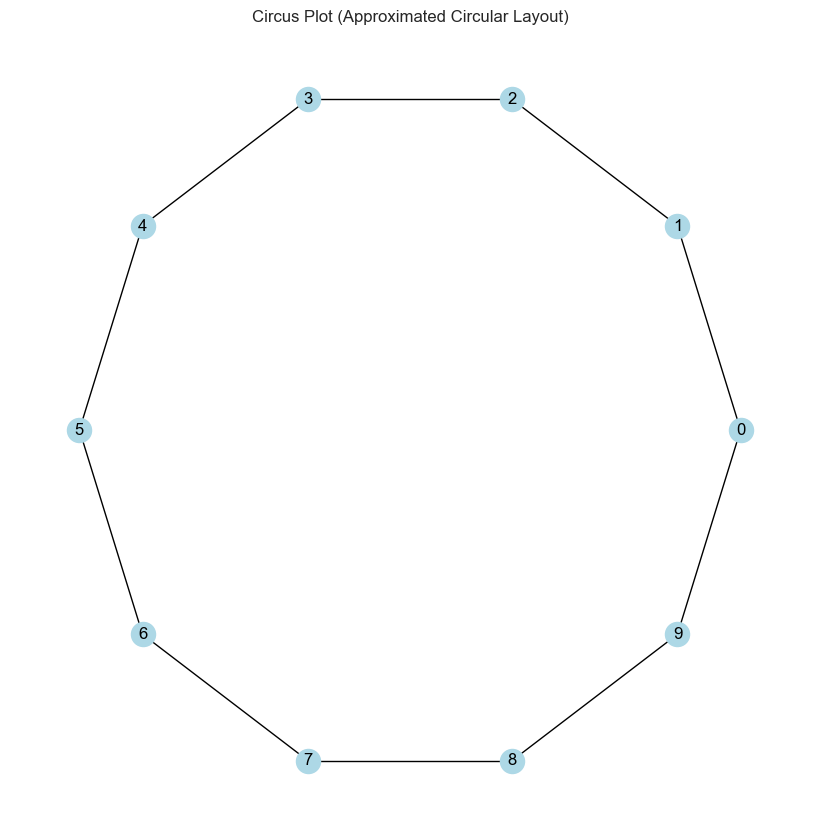

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Synthetic genomic relationships (simple circular graph)
G = nx.cycle_graph(10)
pos = nx.circular_layout(G)

# Plot
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.title('Circus Plot (Approximated Circular Layout)')
plt.show()